In [173]:
import os
import sys 
import csv
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from visual_genome.local import VisualGenome


In [2]:
vg = VisualGenome()

Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data
Loading data...
Data loaded.


In [3]:
import torch
torch.cuda.is_available()

True

In [21]:
models = [
    'all-mpnet-base-v2',  # approx 8 min to load the model
    'gte-large-en-v1.5',  # approx 17 min to load the model
]
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # takes approx 5 min to load

# model = SentenceTransformer("all-mpnet-base-v2", trust_remote_code=True).cuda()
model_name = 'all-mpnet-base-v2'

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
def get_embeddings(model, region_sentences):
    sentence_embeddings = model.encode(region_sentences)
    return sentence_embeddings

In [176]:
def preprocess_text(text):
    # Define a mapping of special characters to their English counterparts
    replacements = {
        'á': 'a',
        'é': 'e',
        'ç': 'c',
        'ÿ': 'y',
        'ñ': 'n'
    }
    
    # Create translation table
    translation_table = str.maketrans(replacements)
    
    # Replace special characters, remove commas, underscores, and convert to lowercase
    text = text.translate(translation_table)   # Replace special characters
    text = text.replace(",", "").replace("_", " ")  # Remove commas and replace underscores with spaces
    text = text.lower()  # Convert to lowercase
    
    return text

In [186]:
def process_entity(entity):
    
    entity_list = {}
    aux = {}
    images = vg.get_images()
    
    for id in vg.get_image_ids():
        if entity == "regions":
            image_regions = images[id]["regions"]
            region_sentences = []
            for region in image_regions:
                region_sentences.append(preprocess_text(region.phrase))
            
            entity_list[id] = region_sentences
        elif entity == "objects":
            image_objects = vg.get_image_objects(id)
            object_names = []
            object_sizes = []
            for obj in image_objects:
                object_names.append(preprocess_text(obj.name))
                object_sizes.append(obj.width * obj.height)
            entity_list[id] = object_names
            aux[id] = object_sizes
        elif entity == "relationships":
            rels = vg.get_image_relationships(id)
            rel_sentences = []
            for rel in rels:
                object = preprocess_text(rel.object_name)
                subject = preprocess_text(rel.subject_name)
                predicate = preprocess_text(rel.predicate)
                
                rel_sentences.append(f"{subject} {predicate} {object}")
            entity_list[id] = (rel_sentences)
        else: 
            print("Invalid entity")
            return None
    
    return entity_list, aux
            

In [187]:
def get_embeddings_from_entity(img_to_entity, model, dim):
    img_to_entity_embeddings = {}
    for im in tqdm(img_to_entity.keys()):
        entity_list = img_to_entity[im]
        if entity_list:
            embeddings = get_embeddings(model, entity_list)
        else:
            embeddings = torch.zeros(dim)  # embedding dimensions of the model
        img_to_entity_embeddings[im] = embeddings
    return img_to_entity_embeddings

In [195]:
def calculate_similarities(img_to_entity_embeddings, model, aux = None):
    img_to_avg_similarities = {}
    img_to_similarity_vec = {}
    for im in tqdm(img_to_entity_embeddings.keys()):
        
        sim = model.similarity(img_to_entity_embeddings[im], img_to_entity_embeddings[im])
        if aux:
            weights = np.array(aux[im])
            square = np.sqrt(weights)
            
            wij = np.outer(square, square)
            sim = sim * wij
            
            wij_vectorized = np.triu(wij, k=1)
            sim_vectorized = np.triu(sim, k=1)
            
            mean = wij_vectorized.sum() / sim_vectorized.sum() 
            img_to_avg_similarities[im] = mean
        else:
            vec = sim[np.triu_indices(len(sim), k=1)]
            img_to_avg_similarities[im] = vec.mean()
            img_to_similarity_vec[im] = vec
            
    return img_to_avg_similarities, img_to_similarity_vec

In [189]:
def plot(img_to_avg_similarities, text):
    plt.hist(list(img_to_avg_similarities.values()), bins=100)
    plt.title(f"text")
    plt.xlabel("Average Similarity")
    plt.ylabel("Frequency")
    plt.show()

In [207]:
def sample_images(img_to_avg_region_similarities, lo, hi):
    similar_images = [k for k, v in img_to_avg_region_similarities.items() if v >= hi]
    dissimilar_images = [k for k, v in img_to_avg_region_similarities.items() if v <= lo]
    
    similar_ims = list(np.random.choice(similar_images, 9))
    dissimilar_ims = list(np.random.choice(dissimilar_images, 9))

    print("Similar images")
    vg.visualize_images_side_by_side(similar_ims)
    print("Dissimilar images")
    vg.visualize_images_side_by_side(dissimilar_ims)
    
    return similar_ims, dissimilar_ims

In [191]:
def save_to_csv(img_to_avg_similarities, filename):
    # write img_to_avg similarities to csv
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["image_id", "avg_similarity"])
        for key, value in img_to_avg_similarities.items():
            writer.writerow([key, value])
    

def write_to_features(img_to_avg_similarities, field):
    features = pd.read_csv("features.csv")
    features[field] = features["image_id"].apply(lambda x: img_to_avg_similarities[x])
    features.to_csv("features.csv", index=False)
    

In [192]:
def get_spearman_corr(img_to_avg_similarities_1, img_to_avg_similarities_2):
    list1 = []
    list2 = []
    for idx, x in enumerate(img_to_avg_similarities_1):
        if str(x) != 'nan' and str(img_to_avg_similarities_2[idx]) != 'nan':
            list1.append(x)
            list2.append(img_to_avg_similarities_2[idx])
    
    print(spearmanr(list1, list2))

In [ ]:
img_to_regions, _ = process_entity("regions")
img_to_region_embeddings = get_embeddings_from_entity(img_to_regions, model, 768)
img_to_avg_region_similarities, img_to_region_similarity_vec = calculate_similarities(img_to_region_embeddings, model)

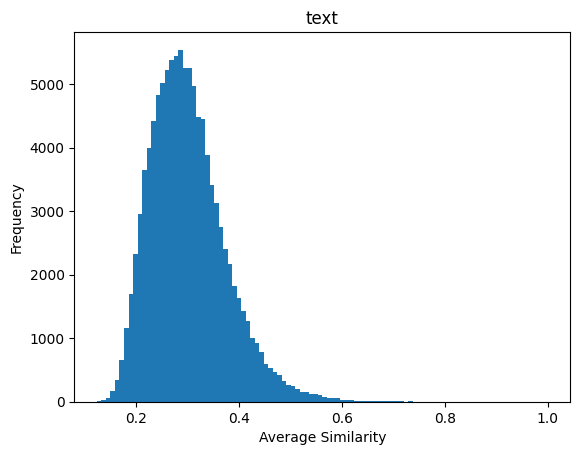

In [197]:
plot(img_to_avg_region_similarities, "Average Similarity in Images based on Region Descriptions")

[2386869, 2330192, 2330749, 2382723, 2373035, 3128, 2338311, 2374414, 738]
[2360840, 2360939, 2389316, 2336405, 1593155, 2320861, 2362239, 2384578, 2317278]


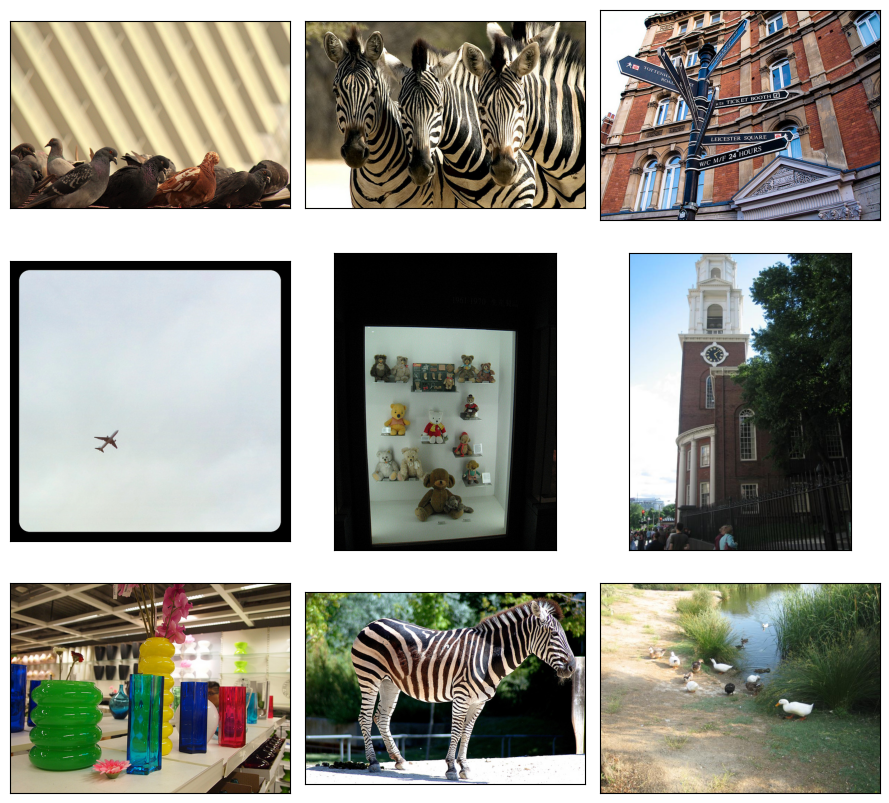

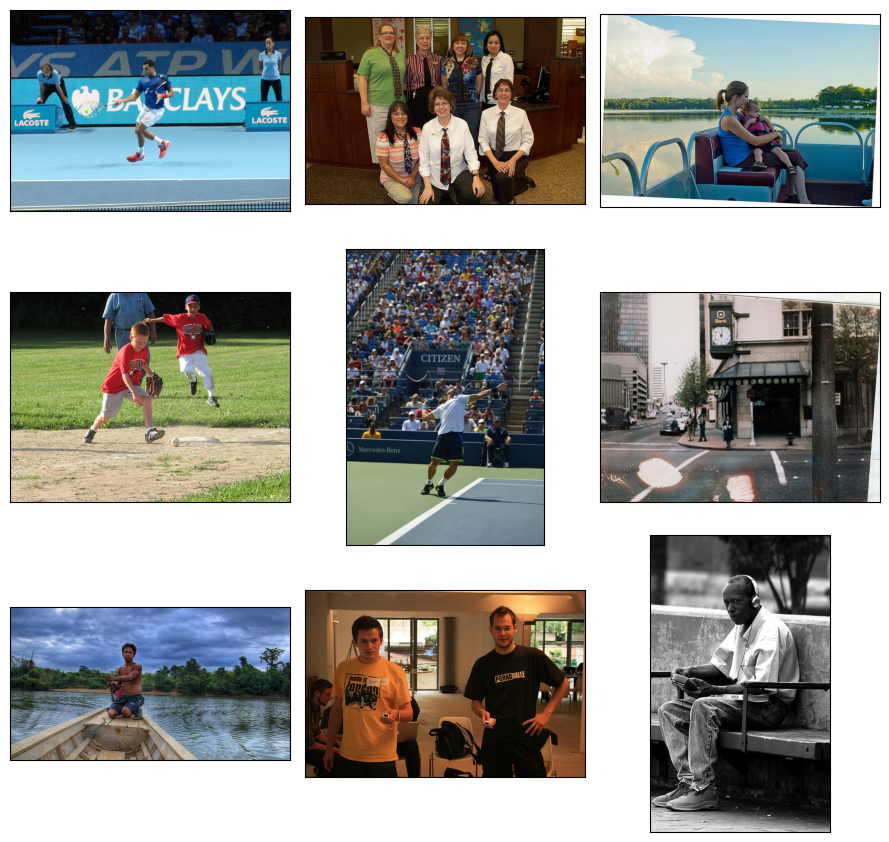

([id: 2386869, coco_id: 181034, flickr_id: 9480115279, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2386869.jpg,
  id: 2330192, coco_id: -1, flickr_id: 2692923748, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2330192.jpg,
  id: 2330749, coco_id: -1, flickr_id: 2152065952, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2330749.jpg,
  id: 2382723, coco_id: 455943, flickr_id: 5343003555, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2382723.jpg,
  id: 2373035, coco_id: -1, flickr_id: 4741619488, width: 375, url: https://cs.stanford.edu/people/rak248/VG_100K/2373035.jpg,
  id: 3128, coco_id: -1, flickr_id: -1, width: 600, url: https://cs.stanford.edu/people/rak248/VG_100K_2/3128.jpg,
  id: 2338311, coco_id: -1, flickr_id: 6228978551, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2338311.jpg,
  id: 2374414, coco_id: 137734, flickr_id: 677921002, width: 500, url: https://cs.stanford.edu/people/rak248/VG

In [208]:
sample_images(img_to_avg_region_similarities, 0.25, 0.5)

## Objects

In [ ]:
img_to_objects, img_to_object_sizes = process_entity("objects")
img_to_object_embeddings = get_embeddings_from_entity(img_to_objects, model, 768)
img_to_avg_object_similarities, img_to_object_similarity_vec = calculate_similarities(img_to_object_embeddings, model)

In [ ]:
plot(img_to_avg_object_similarities, "Average Similarity in Images based on Objects")

In [ ]:
sample_images(img_to_avg_object_similarities, 0.25, 0.5)

## <Subject, Predicate, Object> Triples